# Practical work 5: edge detection

The goal of this course is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [34]:
# Useful modules
%matplotlib inline

import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def niceDisplay14(affichages,titres=None):
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

def imshow(I, title=None, size=500, axis=False):
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    # try to uncomment next line for better visualisation
    # plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

# useful functions saved from last week
def imagePad(I,h):
    image = I.copy()
    image = np.pad(image,int(h.shape[0]/2),'constant')
    return image

def gaussianKernel(sigma):
    n = 2*np.ceil(3*sigma) + 1
    x,y = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
    return  np.exp( (-x**2-y**2)/(2*sigma*sigma))

## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [35]:
# Some intermediate results from the Sobel detector might also play a role outside this function
# (as we do not always require the thresholding to be present).
# We hence chose to define two versions of it:

def SobelPhase1(I):
    # This one computes the gradient:
    sobelx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) # predefined horizontal Sobel filter
    sobely = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) # predefined vertical Sobel filter
    horizontal = convolve2d(I,sobelx)
    vertical = convolve2d(I,sobely)
    gradient = np.sqrt(horizontal**2 + vertical**2)
    return horizontal, vertical, gradient

def SobelDetector(I,s):
    # This one applies a threshold on it:
    gradient = SobelPhase1(I)[2]
    edges = np.where(gradient>s,1,0) 
    return edges

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and determines the zero crossings of the Laplacian. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [36]:
def LaplacianDetector(I,s):
    edges = np.zeros(I.shape) # to retain edge localisation
    
    # The Laplacian filter consists in a convolution with the following kernel:
    kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]]) 
    convolved = convolve2d(I,kernel)
    padded = imagePad(convolved,kernel) # ... and since we're considering neighbourhoods, zero-padding is required
    
    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            # for each pixel, compute a 3*3 window that is centered on it
            window = padded[x:x+kernel.shape[0],y:y+kernel.shape[0]]
            # find maximum and minimum of said window
            w_max = np.amax(window) 
            w_min = np.amin(window)
            # highlight all the zero-crossings
            if (w_max>0 and w_min<0 and w_max-w_min > s):
                edges[x,y] = 1
    return edges

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.gif`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

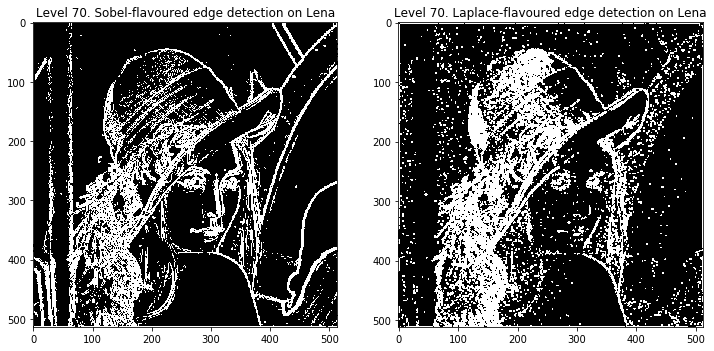

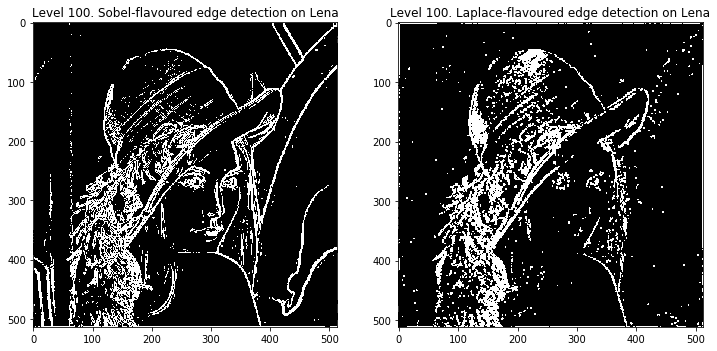

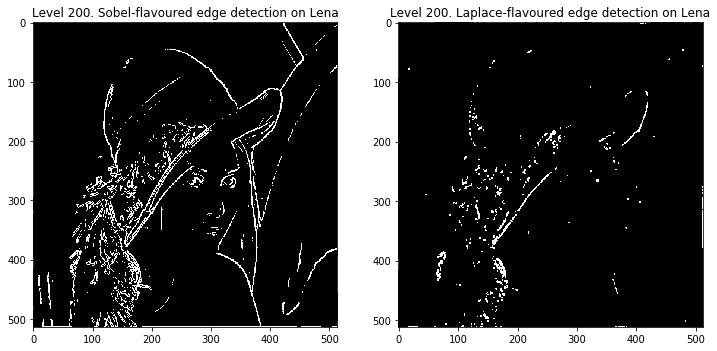

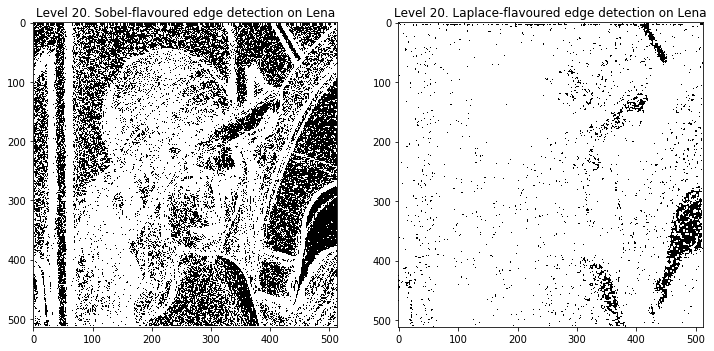

In [9]:
imageLena = np.array(Image.open('img/lena.png'))

sobelLena = SobelDetector(imageLena,70)
laplaceLena = LaplacianDetector(imageLena,70)
niceDisplay14([sobelLena,laplaceLena],
              ["Level 70. Sobel-flavoured edge detection on Lena","Level 70. Laplace-flavoured edge detection on Lena"])

sobelLena = SobelDetector(imageLena,100)
laplaceLena = LaplacianDetector(imageLena,100)
niceDisplay14([sobelLena,laplaceLena],
              ["Level 100. Sobel-flavoured edge detection on Lena","Level 100. Laplace-flavoured edge detection on Lena"])

sobelLena = SobelDetector(imageLena,200)
laplaceLena = LaplacianDetector(imageLena,200)
niceDisplay14([sobelLena,laplaceLena],
              ["Level 200. Sobel-flavoured edge detection on Lena","Level 200. Laplace-flavoured edge detection on Lena"])

sobelLena = SobelDetector(imageLena,20)
laplaceLena = LaplacianDetector(imageLena,20)
niceDisplay14([sobelLena,laplaceLena],
              ["Level 20. Sobel-flavoured edge detection on Lena","Level 20. Laplace-flavoured edge detection on Lena"])

The comparison between these two detectors shows that the Laplacian is highly sensitive to noise. It detects random dots and marks them as edges, as long as they differ from their immediate neighbours - while it somehow misses some of the actual closed outlines of the objets, such as Lena's nose, or Lena's reflection on the mirror. 

In both cases, increasing the threshold s decreases the filter's sensitivity. It naturally results in detecting fewer edges on the final image. However, we notice that the Sobel detector always yields better results, as the represented objects stay recognisable whatever the threshold value is. Since it relies on gradients, it systematically detects any progressive variations in hues, and such structures stay readable at all sensitivity levels.

Both detectors would find approximately the same edges for a threshold parameter equal to 70.

## Exercice 2: Non maximum suppresion

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.gif`. Verify values according to the different local orientation configurations (use `imshow()` in interactive mode in the nootebook and with the colormap `hot()`).

<IPython.core.display.Javascript object>


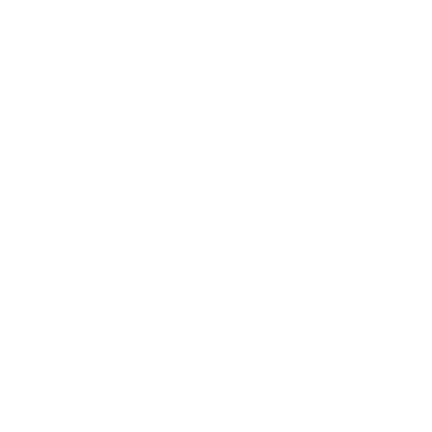

<IPython.core.display.Javascript object>


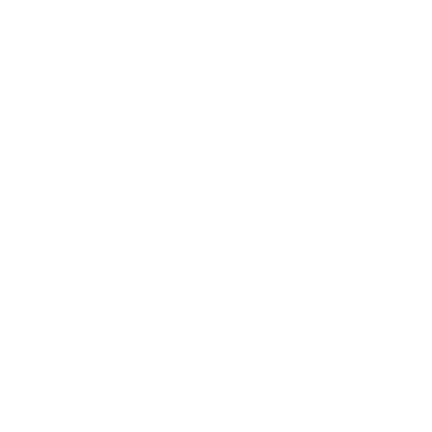

In [38]:
%matplotlib notebook
imageTools = np.array(Image.open("img/tools.png"))

# SobelPhase1() allows us to retrieve the spatial derivatives 
# and gradient norm for any picture.
xTools, yTools, gradTools = SobelPhase1(imageTools)
oriTools = orientation(xTools, yTools, gradTools)
imshow(oriTools,"Computing gradient orientation for basic shapes")

Explain the different values given to a pixel by `orientation()`:

orientation() would assign four (actually five) possible values to each pixel in the image : 1, 2, 3, 4 (and 0).

Based on the plt.hot() colour scheme, the following decomposition might be more telling:
* The value 1, shown in red, means that the computed gradient is horizontal ($\frac {0\pi}4 >> \frac {1\pi}4$): this pixel is part of a vertical edge.

* The value 2, shown in orange, means that the computed gradient is an ascending diagonal ($\frac {1\pi}4 >> \frac {2\pi}4$): this pixel is part of a descending diagonal edge.

* The value 3, shown in yellow, means that the computed gradient is vertical ($\frac {2\pi}4 >> \frac {3\pi}4$): this pixel is part of a horizontal edge.

* The value 4, shown in white, means that the computed gradient is a descending diagonal ($\frac {3\pi}4 >> \frac {4\pi}4$): this pixel is part of an ascending diagonal edge.

* (orientation() also assigns a null value to any pixel that is not part of a detected edge - and turns it black.)

Considering only thresholds valued at $\frac {0\pi}4$, $\frac {1\pi}4$, $\frac {2\pi}4$ and $\frac {3\pi}4$ suffices since 
* $\frac {k\pi}4 mod 2\pi$ and $\frac {(k+4)\pi}4 mod 2\pi$ represent the same direction.

* we do not need a higher level of precision.

2. Write a function `nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning a binary image: pixels set to 1 have should a maxima norm gradient in the direction of the gradient.

In [37]:
def nms(Ig, Ior):
    # For each pixel marked as an edge, 
    # make sure that its gradient norm is maximal in the required direction.
    
    edges = np.zeros(Ig.shape)
    padded = imagePad(Ig,np.zeros((3,3))) # padding needed - we're considering neighbourhoods
    
    # The position of the pixels used for the comparison will vary depending on the
    # gradient orientation. We will have to consider four cases, or maybe five if 0 counts as one:
    
    for i in range(Ig.shape[0]):
        for j in range(Ig.shape[1]):
            # whatever happens next, start by initialising comparison points at the highest, so that they "always win".
            A = float('inf') 
            B = float('inf')
            if Ior[i,j]==1:
                # CASE 1: potential vertical edge. as for the comparison points, look at the pixels standing beside it.
                A = padded[i+1,j]
                B = padded[i+1,j+2]
            if Ior[i,j]==2:
                # CASE 2: potential descending diagonal edge. look at the pixels that define the complimentary diagonal.
                A = padded[i,j+2]
                B = padded[i+2,j]
            if Ior[i,j]==3:
                # CASE 3: potential horizontal edge. look at the pixels standing above and below.
                A = padded[i,j+1]
                B = padded[i+2,j+1]
            if Ior[i,j]==4:
                # CASE 4: potential ascending diagonal edge. look at the pixels that define the complimentary diagonal.
                A = padded[i,j]
                B = padded[i+2,j+2]
                
            # verify the maximum property:
            # compare gradient with that of the adequate pixels A and B, whatever A and B got valued at.
            
            if max(Ig[i,j],A,B)==Ig[i,j]:
                edges[i,j] = Ig[i,j]
                
            # Three cases might occur:
            # CASE 1
            # if A and B were not modified after initialisation, i.e. if Ior[i,j] == 0, 
            # then there is no chance for Ig[i,j] to be greater than infinity -
            # and the pixel will not be marked as an edge.
            
            # CASE 2            
            # if A and B actually were modified, 
            # but if their values could not compete with the strong gradient
            # found in position (i,j), then we are standing on an edge pixel:
            # make it visible by turning it white.
            
            # CASE 3            
            # else, whatever the gradient is on pixel (i,j),
            # it is not meaningful enough to indicate an edge;
            # either of A or B won against Ig[i,j],
            # so nothing happens, just as in case 1.
            
    return edges

3. Experiments function `nms()` on images `img/tools.gif` and `img/lena.gif` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


<IPython.core.display.Javascript object>


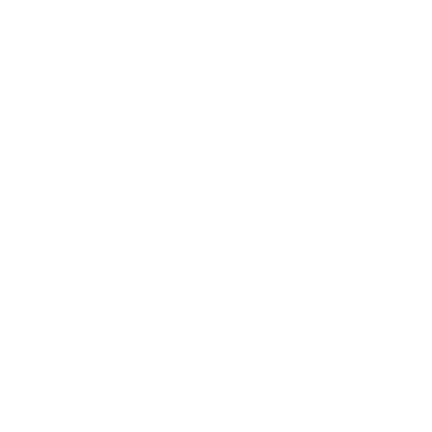

<IPython.core.display.Javascript object>


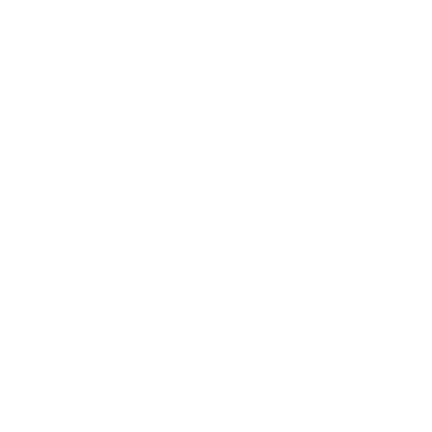

In [39]:
# These edges are thin and complete.
# Careful, they might not show in their entirety depending on your window resolution.
edgeTools = nms(gradTools,oriTools)
imshow(edgeTools,"Edge detection for basic shapes")

In [40]:
def GetEdgesWithGaussian(I,sigma):
    kernel = gaussianKernel(sigma) # reused from last session
    gaussI = convolve2d(I,kernel) # apply Gaussian filter,
    xI, yI, gradI = SobelPhase1(gaussI) # get spatial derivatives and gradient norm,
    oriI = orientation(xI, yI, gradI) # compute and discretise gradient orientation
    return gradI, oriI

<IPython.core.display.Javascript object>


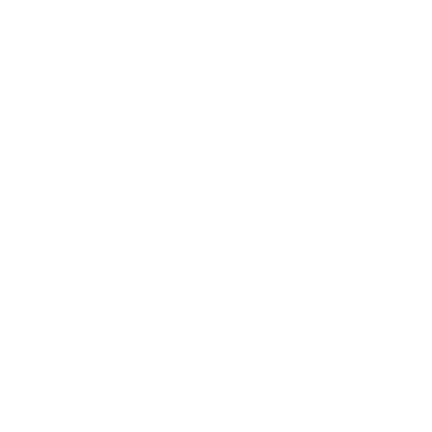

<IPython.core.display.Javascript object>


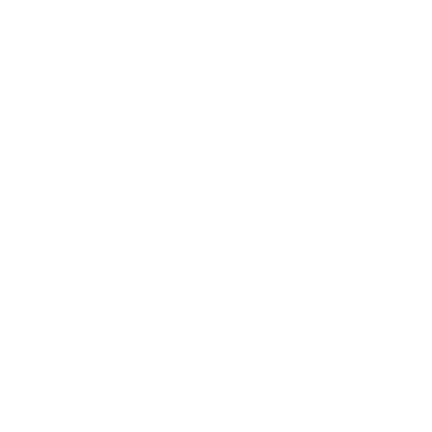

In [41]:
%matplotlib inline
# applying a Gaussian filter
gradToolsGauss,oriToolsGauss = GetEdgesWithGaussian(imageTools,2) # dispersion parameter = 2
edgeToolsGauss = nms(gradToolsGauss,oriToolsGauss)
imshow(edgeToolsGauss,"Edge detection with Gaussian kernel")

In [ ]:
# Lena's turn!
xLena, yLena, gradLena = SobelPhase1(imageLena)
oriLena = orientation(xLena, yLena, gradLena)
edgeLena = nms(gradLena,oriLena)

# applying a Gaussian filter
gradLenaGauss,oriLenaGauss = GetEdgesWithGaussian(imageLena,2)
edgeLenaGauss = nms(gradLenaGauss,oriLenaGauss)

# one move further
gradLenaSuperGauss,oriLenaSuperGauss = GetEdgesWithGaussian(imageLena,5)
edgeLenaSuperGauss = nms(gradLenaSuperGauss,oriLenaSuperGauss)

plt.figure()
niceDisplay14([edgeLena,edgeLenaGauss,edgeLenaSuperGauss],
              ["Portrait edge detection","Portrait edge detection with Gaussian kernel","Portrait edge detection with broad Gaussian kernel"])

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

Smoothing helps the program sharpen its wits and separate the noise from the actual valuable edges,
by discarding the highest frequencies that usually build up a texture's detail:
noise could be interpreted as some kind of texture and we do not want it to be visible.

Using a Gaussian filter does not make sense on tools.gif, but Lena, for instance, is a very noisy image.

The higher the $\sigma$, the sparser the edges. Of course, they also get slightly thicker because of the subsidiary blur that occurs when applying such a filter.

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.gif`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

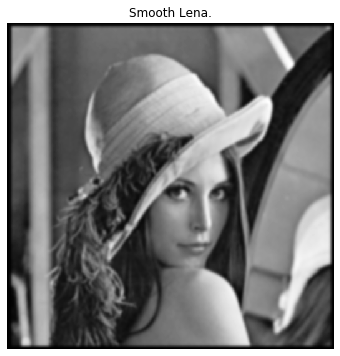

In [27]:
%matplotlib inline 
gauss2 = gaussianKernel(2)
gaussLena = convolve2d(imageLena,gauss2)
imshow(gaussLena,"Smooth Lena.")

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

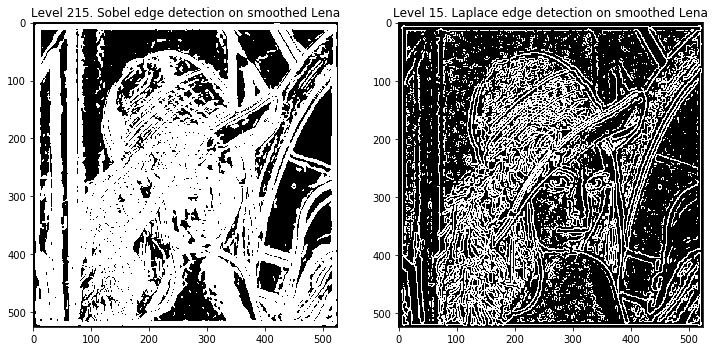

In [29]:
sobelLena = SobelDetector(gaussLena,215)
laplaceLena = LaplacianDetector(gaussLena,15)
niceDisplay14([sobelLena,laplaceLena],
              ["Level 215. Sobel edge detection on smoothed Lena","Level 15. Laplace edge detection on smoothed Lena"])

This confirms the hypothesis according to which the Laplacian detector is sensitive to noise. We saw it yielding a very poor result earlier, but little did we know that it had such interesting outcomes when prepared with a Gaussian filter (which is a noise canceller). At the same time, the Sobel detector generated very thick lines that made the result fully unreadable. All the detected edges fuse and overflow together. The level of detail of Lena's face seems to be too much to handle. 

With the chosen values, both actually "see" the same things, and approximately trace the same shapes in the edge map. Yet, both edge maps are visually very different, as they are reflected with different line thicknesses. What does that mean ?

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

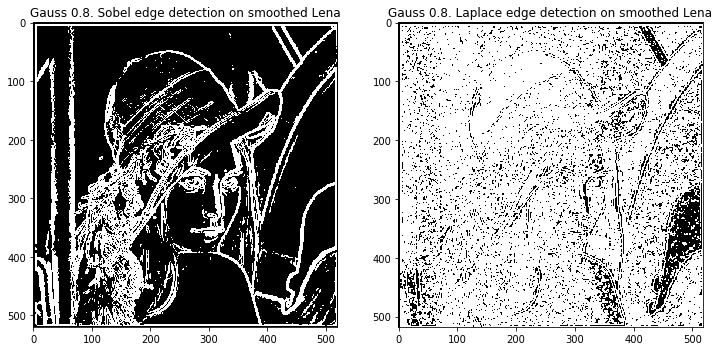

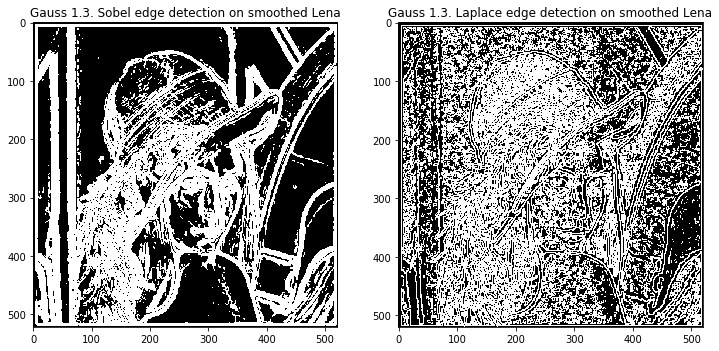

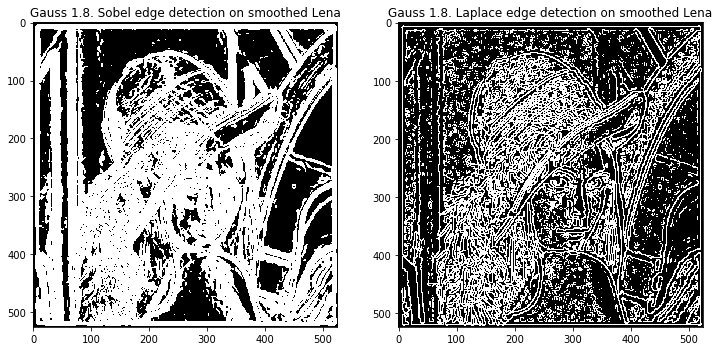

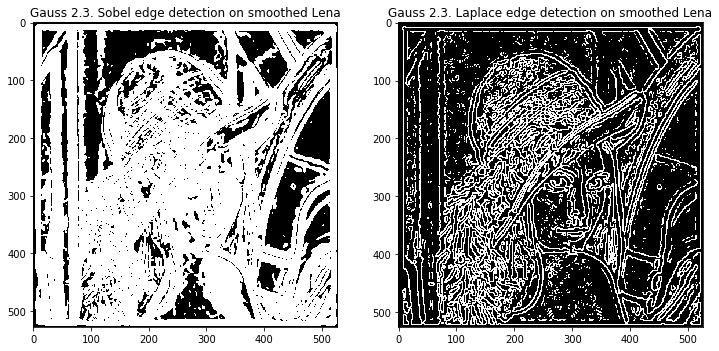

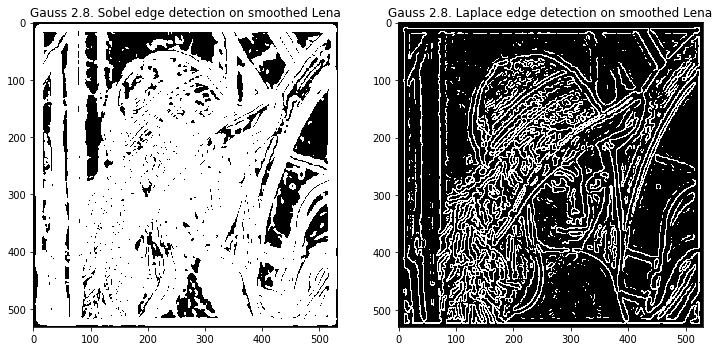

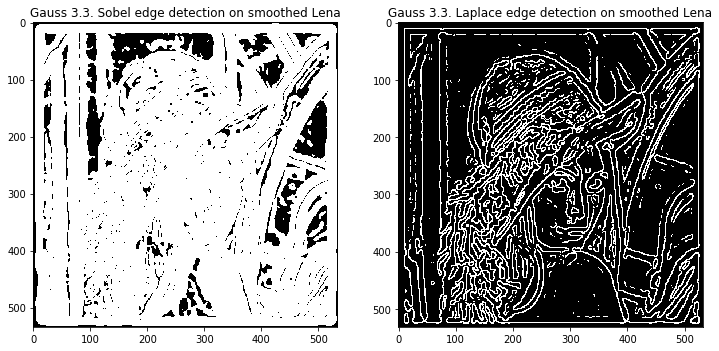

In [30]:
# The choice of the start and end points for the sigma run depends on empirical tests -
# we wanted to start with a value where the Sobel filter still performs better, 
# and see how the Laplace progressively takes the lead. 
# We stop the experiment whenever readability on the right side reaches a sufficient level,
# more or less comparable to the initial case of the Sobel filter.

sigma=0.8
while sigma<3.8:
    gauss = gaussianKernel(sigma)
    gaussLena = convolve2d(imageLena,gauss)

    sobelLena = SobelDetector(gaussLena,215)
    laplaceLena = LaplacianDetector(gaussLena,15)
    niceDisplay14([sobelLena,laplaceLena],
                  ["Gauss %.1f. Sobel edge detection on smoothed Lena" % sigma,"Gauss %.1f. Laplace edge detection on smoothed Lena" % sigma])
    sigma+=0.5

Smoothing reduces the noise, but does it help detect a contour with precision?

The Laplacian filter has a "scatter plot" mode of action. It raises a flag where it detects a punctual variation.
A Gaussian filter reduces the difference between a pixel and its neighbours. It is enough to annihilate the lightest noise distributions, but it keeps contrasted lines untouched.
Thus, while noise dwindles, the scattered dots will look like they're drawn exclusively from the most coherent lines. Few of them will be still lost in the background, as they were before the smoothing. 
It makes the result more readable, so it might seem to be more precise, but it's not. This is just about cutting the most irrelevant data. Reducing the noise just cleans up a bit of the chaos, but a Laplacian with a Gaussian still does not perform as well as a Sobel alone.

The Sobel detector for its part loses most of its accuracy after the smoothing. For the record, it relies on gradient computation - treats each pixel as a part of a transitional frontier, searches for such frontiers and reflects them with very thin white lines. Such a detector wouldn't be able to handle a case where these frontiers are too broad and diffuse, and that's why a Gaussian filter gets it into trouble. Gaussian filtering adds a blur, in other words, it increases the gradient's "thickness"; the transition speed between any two regions become too slow, so duplicate detected edge lines accumulate into a pool of white pixels.

In short,
* Sobel monitors the gradient's evolution across neighbourhoods. Light noise distributions do not interfere into that, so they are quite easy to resist. Since noise cancellation blurs the frontiers between objects, it actually doesn't help at all : working with thicker lines just means duplicate detection, hence bad localisation.
* Laplace needs a noise canceller to work at its best. Remember - noise cancellation does not increase precision, but it helps keep only the most significative edges (that would ALSO be detected, among others, without it).

4. Replace the gaussian filter by a constrast enhancer filter. Discuss the results

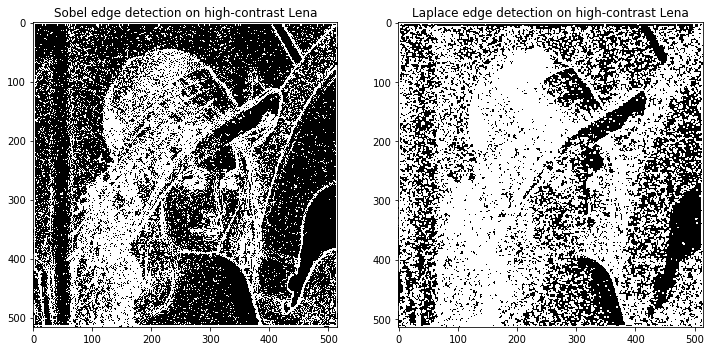

In [31]:
# The following kernel was drawn from the lecture's slides.
contrast = [[0,-1,0],[-1,5,-1],[0,-1,0]]
contrastLena = convolve2d(imageLena,contrast)

sobelLena = SobelDetector(contrastLena,100)
laplaceLena = LaplacianDetector(contrastLena,250)
niceDisplay14([sobelLena,laplaceLena],
              ["Sobel edge detection on high-contrast Lena","Laplace edge detection on high-contrast Lena"])

Even though the noise is back, and louder as ever since it is now highly contrasted, the Sobel filter performs really well. The display is impacted, but the edges still seem to weigh more where they really matter (around the eyes, on the mirror's shape, etc.). Indeed, the strongest gradient variations are still there, still visible, and are detected as they should.

The Laplacian though does not yield a recognisable image. As we said before, it reacts badly to noisy pictures, for it applies the exact same treatment to dots that are *actually* linked by a line as to dots that are just randomly generated on the background. In short, any point that stands out, to a certain extent, from its immediate neighbours (and we already said that noise does) will be recognised as an edge. Augmenting the contrast just results in facilitating the threshold trespassing, hence wrongfully augmenting the filter's sensitivity to these random variations.

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

In [94]:
def subSample2(I):
    return I[::2,::2]

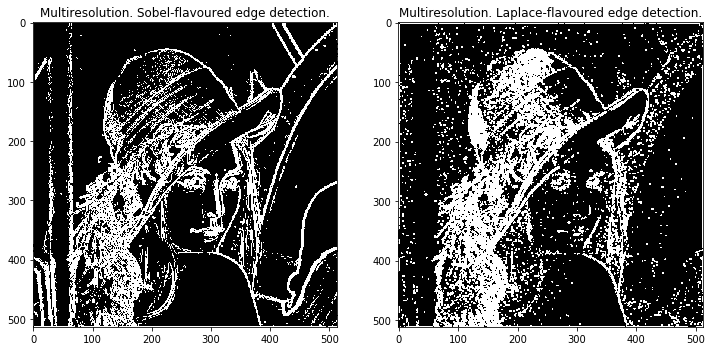

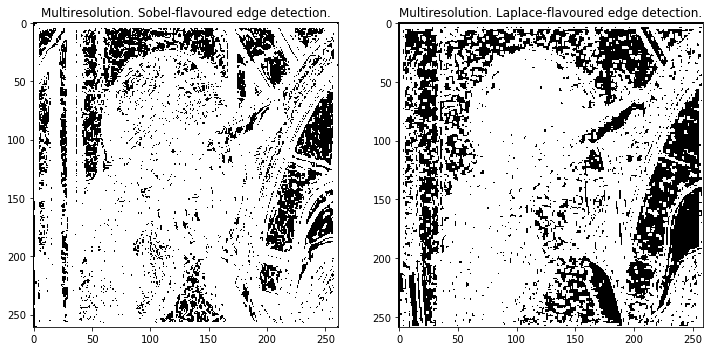

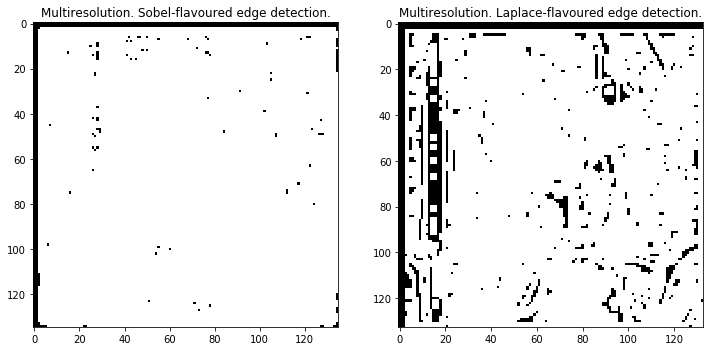

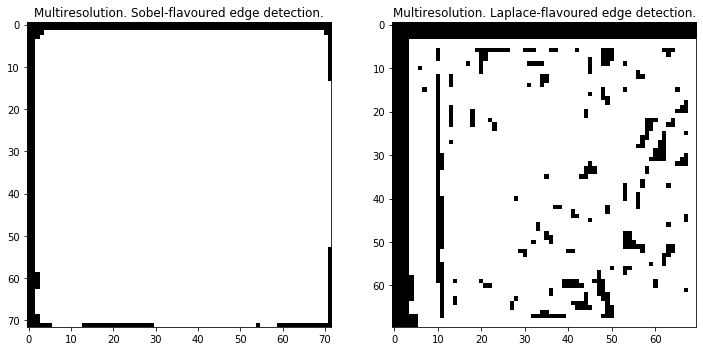

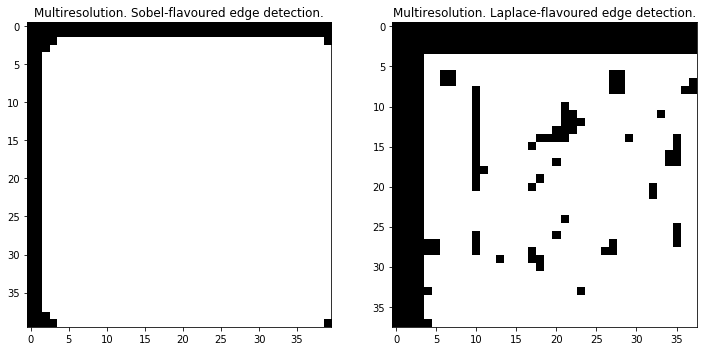

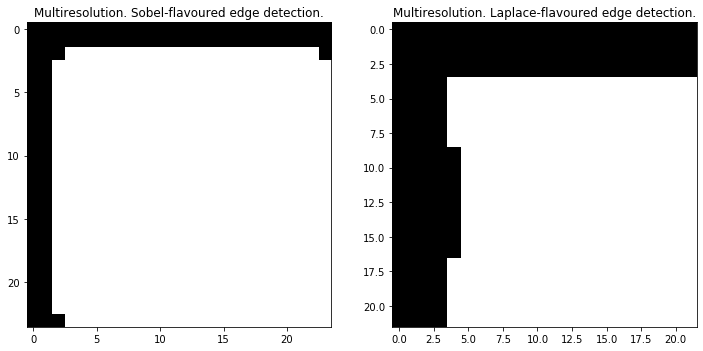

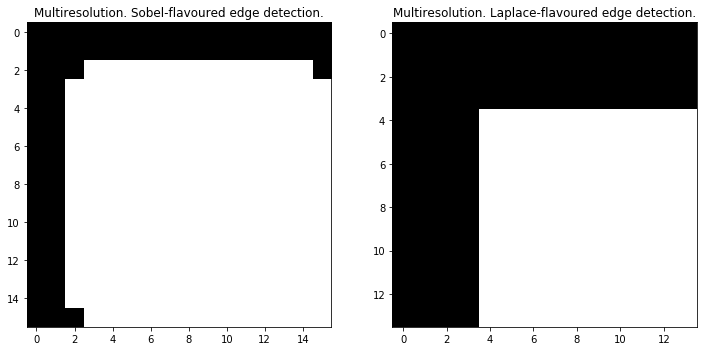

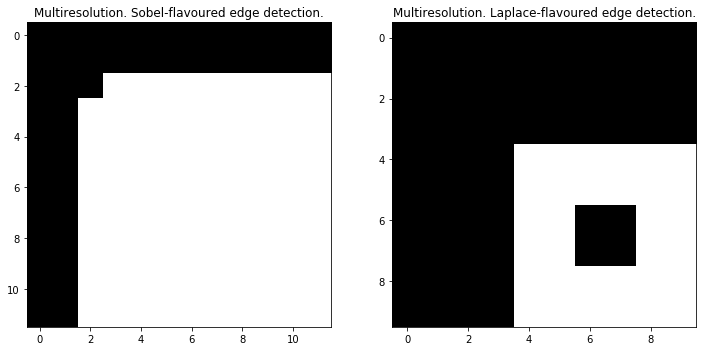

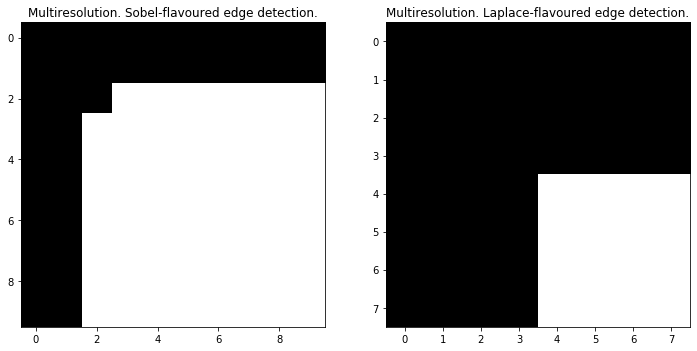

In [139]:
# In order to halt the loop, sigma must not exceed 1. 

sampleLena = imageLena.copy()

sobelLena = SobelDetector(sampleLena,70)
laplaceLena = LaplacianDetector(sampleLena,70)
niceDisplay14([sobelLena,laplaceLena],
          ["Multiresolution. Sobel-flavoured edge detection.","Multiresolution. Laplace-flavoured edge detection."])

while (sampleLena.shape[0]>8):
    gauss = gaussianKernel(1)
    gaussLena = convolve2d(sampleLena,gauss)
    sampleLena = subSample2(gaussLena)
    
    sobelLena = SobelDetector(sampleLena,70)
    laplaceLena = LaplacianDetector(sampleLena,70)
    niceDisplay14([sobelLena,laplaceLena],
              ["Multiresolution. Sobel-flavoured edge detection.","Multiresolution. Laplace-flavoured edge detection."])

Although most of the data are very obviously lost on both sides, it looks like the Laplacian is more robust to subsampling than the Sobel filter is. - Of course, we're setting it in the right conditions thanks to the Gaussian filter: noise is cut as it should be. -  
In other words, for picture sizes down to 8x8, something is still "happening" on the right-hand edge maps, while the left-hand maps have simply been reduced to blank squares three steps ago.

Subsampling confuses the orientation matrix of a picture. The farther you sample, the more adjacent pixels will point to contradictory directions. The coherence between the lines and columns is broken as one in every two is purely taken out of the structure at each step; it means that you will soon end up comparing neighbours that were not even close together in the original picture. Maximising a gradient in such a situation does not make much sense...  
...whereas the Laplacian still counts on punctual intensity variations, which can still be meaningful even in subsampling contexts. A dark dot or a pool of dark dots found in the middle of nowhere can only indicate that a bigger, complete complex object was initially standing there.  
That might be an explanation.